In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import json
from datetime import datetime
from copy import deepcopy
from typing import (
    Any,
    AsyncIterable,
    Callable,
    Dict,
    Generator,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union,
)
import requests
from io import BytesIO

from PIL import Image
import torch
from accelerate import infer_auto_device_map, load_checkpoint_and_dispatch, init_empty_weights

from data.transforms import ImageTransform
from data.data_utils import pil_img2rgb, add_special_tokens
from modeling.bagel import (
    BagelConfig, Bagel, Qwen2Config, Qwen2ForCausalLM, SiglipVisionConfig, SiglipVisionModel
)
from modeling.qwen2 import Qwen2Tokenizer
from modeling.bagel.qwen2_navit import NaiveCache
from modeling.autoencoder import load_ae

/opt/conda/envs/bagel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def display_alongside_batch(img_list, resize_dims=(512,512)):
    if isinstance(resize_dims, int):
        resize_dims = (resize_dims,resize_dims)
    res = np.concatenate([np.array(img.resize(resize_dims)) for img in img_list], axis=1)
    return Image.fromarray(res)

In [4]:
!$PYTHONPATH

In [15]:
# Set paths for your trained checkpoint
# checkpoint_dir = "./models/Bagel-Zebra-CoT/"
checkpoint_dir = "./results/bagel-frozenlake-thinktrace-256dim-visual-cot-v1/checkpoints/0000200_hf/"
# checkpoint_file = "ema.safetensors"
checkpoint_file = "model.safetensors"

checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)


print(f"Available GPUs: {torch.cuda.device_count()}")
print(f"GPU memory per device:")
for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    print(f"  GPU {i}: {props.name}, {props.total_memory / 1e9:.1f} GB")

Available GPUs: 8
GPU memory per device:
  GPU 0: NVIDIA H100 80GB HBM3, 84.9 GB
  GPU 1: NVIDIA H100 80GB HBM3, 84.9 GB
  GPU 2: NVIDIA H100 80GB HBM3, 84.9 GB
  GPU 3: NVIDIA H100 80GB HBM3, 84.9 GB
  GPU 4: NVIDIA H100 80GB HBM3, 84.9 GB
  GPU 5: NVIDIA H100 80GB HBM3, 84.9 GB
  GPU 6: NVIDIA H100 80GB HBM3, 84.9 GB
  GPU 7: NVIDIA H100 80GB HBM3, 84.9 GB


In [16]:
# LLM config preparing (use base model configs)
llm_config = Qwen2Config.from_json_file(os.path.join(checkpoint_dir, "llm_config.json"))
llm_config.qk_norm = True
llm_config.tie_word_embeddings = False
llm_config.layer_module = "Qwen2MoTDecoderLayer"

# ViT config preparing (use base model configs)
vit_config = SiglipVisionConfig.from_json_file(os.path.join(checkpoint_dir, "vit_config.json"))
vit_config.rope = False
vit_config.num_hidden_layers = vit_config.num_hidden_layers - 1

# VAE loading (use base model VAE)
vae_model, vae_config = load_ae(local_path=os.path.join(checkpoint_dir, "ae.safetensors"))

# Bagel config preparing
config = BagelConfig(
    visual_gen=True,
    visual_und=True,
    llm_config=llm_config, 
    vit_config=vit_config,
    vae_config=vae_config,
    vit_max_num_patch_per_side=70,
    connector_act='gelu_pytorch_tanh',
    latent_patch_size=2,
    max_latent_size=64, # default is 64
)

# Create model with empty weights - IMPORTANT: Use float32 initially to match checkpoint
with init_empty_weights():
    language_model = Qwen2ForCausalLM(llm_config)
    vit_model      = SiglipVisionModel(vit_config)
    model          = Bagel(language_model, vit_model, config)
    model.vit_model.vision_model.embeddings.convert_conv2d_to_linear(vit_config, meta=True)

# Tokenizer Preparing (use base model tokenizer)
tokenizer = Qwen2Tokenizer.from_pretrained(checkpoint_dir)
tokenizer, new_token_ids, _ = add_special_tokens(tokenizer)

# Image Transform Preparing
# vae_transform = ImageTransform(1024, 512, 16)
# vit_transform = ImageTransform(980, 512, 14)

vae_transform = ImageTransform(256, 256, 16)
vit_transform = ImageTransform(256, 256, 14)

In [17]:
# Device mapping for 8x80GB GPUs - use bf16 directly
max_mem_per_gpu = "80GiB"

print("Setting up device mapping...")
device_map = infer_auto_device_map(
    model,
    max_memory={i: max_mem_per_gpu for i in range(torch.cuda.device_count())},
    no_split_module_classes=["Bagel", "Qwen2MoTDecoderLayer"],
    dtype=torch.bfloat16,  # Use bf16 for device mapping
)

print("Device map:", device_map)

# Handle same-device modules
same_device_modules = [
    'language_model.model.embed_tokens',
    'time_embedder',
    'latent_pos_embed',
    'vae2llm',
    'llm2vae',
    'connector',
    'vit_pos_embed'
]

if torch.cuda.device_count() == 1:
    first_device = device_map.get(same_device_modules[0], "cuda:0")
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device
        else:
            device_map[k] = "cuda:0"
else:
    first_device = device_map.get(same_device_modules[0])
    if first_device is not None:
        for k in same_device_modules:
            if k in device_map:
                device_map[k] = first_device

print("Final device map:", device_map)

# Load checkpoint directly in bf16
print(f"Loading checkpoint directly in bfloat16: {checkpoint_path}")
print("Loading model from safetensors file...")

# Load model directly in bf16
model = load_checkpoint_and_dispatch(
    model,
    checkpoint=checkpoint_path,
    device_map=device_map,
    offload_buffers=False,
    dtype=torch.bfloat16,   # Load directly as bf16
    force_hooks=True,
)

model = model.eval()

print('Model loaded directly in bfloat16!')
print(f"Model dtype: {next(model.parameters()).dtype}")
print("Model loading completed successfully!")

# Check memory usage
print("GPU memory usage after loading:")
for i in range(torch.cuda.device_count()):
    if torch.cuda.memory_allocated(i) > 0:
        allocated = torch.cuda.memory_allocated(i) / 1e9
        cached = torch.cuda.memory_reserved(i) / 1e9
        print(f"  GPU {i}: {allocated:.1f}GB allocated, {cached:.1f}GB cached")


The safetensors archive passed at ./results/bagel-frozenlake-thinktrace-256dim-visual-cot-v1/checkpoints/0000200_hf/model.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


Setting up device mapping...
Device map: OrderedDict([('', 0)])
Final device map: OrderedDict([('', 0)])
Loading checkpoint directly in bfloat16: ./results/bagel-frozenlake-thinktrace-256dim-visual-cot-v1/checkpoints/0000200_hf/model.safetensors
Loading model from safetensors file...
Model loaded directly in bfloat16!
Model dtype: torch.bfloat16
Model loading completed successfully!
GPU memory usage after loading:
  GPU 0: 58.7GB allocated, 59.2GB cached


In [7]:
pwd

'/home/colligo/project/vlm/Bagel-Zebra-CoT'

In [18]:
# Rest of inference code
from inferencer import InterleaveInferencer

inferencer = InterleaveInferencer(
    model=model, 
    vae_model=vae_model, 
    tokenizer=tokenizer, 
    vae_transform=vae_transform, 
    vit_transform=vit_transform, 
    new_token_ids=new_token_ids
)

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

inference_hyper=dict(
    do_sample=True,
    text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

In [11]:
!echo $PYTHONPATH

# 1 - Inference Original

In [9]:
INTERLEAVED_SYSTEM_PROMPT = '''You are an AI reasoning assistant capable of step-by-step interleaved text and visual chain of thought. Think step by step and use visual aids to enhance your problem-solving. Provide your final conclusion clearly in the format of "Final Answer: <answer here>"'''

prompt = '''Subtract all cylinders. Add 1 red sphere. How many objects are left?'''
prompt = '''what is in this image? Describe please'''
image = Image.open('test_images/image.png')

print(prompt)
print('-'*50)

# Create output folder with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = f"reasoning_output_{timestamp}"
images_folder = os.path.join(output_folder, "images")
os.makedirs(images_folder, exist_ok=True)

# Save the original problem images if they exist
problem_image_paths = []
if image is not None:
    if isinstance(image, list):
        # Handle multiple images
        for i, img in enumerate(image):
            problem_image_path = os.path.join(images_folder, f"problem_image_{i+1}.png")
            relative_path = os.path.join("images", f"problem_image_{i+1}.png")
            img.save(problem_image_path)
            problem_image_paths.append(relative_path)
            print(f"Problem image {i+1} saved at '{problem_image_path}'")
    else:
        # Handle single image
        problem_image_path = os.path.join(images_folder, "problem_image.png")
        relative_path = os.path.join("images", "problem_image.png")
        image.save(problem_image_path)
        problem_image_paths.append(relative_path)
        print(f"Problem image saved at '{problem_image_path}'")

reasoning_text = []
reasoning_images = []
image_paths = []  # Store relative paths to images

# Create input with multiple images properly flattened
if image is not None:
    if isinstance(image, list):
        current_input = [prompt] + image  # Flatten the list of images
    else:
        current_input = [prompt, image]
else:
    current_input = [prompt]

# Loop until no more vision_start tokens
iteration = 0
while True:    
    # Get understanding output
    print(f"iteration: {iteration}")
    output = inferencer.interleave_inference(current_input, understanding_output=True, system_prompt=INTERLEAVED_SYSTEM_PROMPT, **inference_hyper)

    # Check for stopping conditions
    has_final_answer = 'Final Answer:' in output[0] or '<answer>' in output[0]
    
    # Stop if we have a final answer OR if there's no vision token (no more images to generate)
    # should_stop = has_final_answer or not has_vision_token
    should_stop = has_final_answer


    if should_stop:
        if output[0].strip():
            extracted_text = output[0].split('<|im_end|>')[0].split('<|im_start|>')[1]
            reasoning_text.append(extracted_text)
            print(f"{extracted_text}")
            current_input = current_input + [extracted_text]
        break
    
    extracted_text = output[0].split('<|im_end|>')[0].split('<|im_start|>')[1]
    reasoning_text.append(extracted_text)
    print(f"{extracted_text}")
    
    # Generate image based on current reasoning
    current_input_with_reasoning = current_input + [extracted_text]
    output = inferencer.interleave_inference(current_input_with_reasoning, system_prompt=INTERLEAVED_SYSTEM_PROMPT, **inference_hyper)
    image_output = output[0]

    # Save and collect the generated image
    reasoning_images.append(image_output)
    image_filename = f'reasoning_image_{iteration + 1}.png'
    image_path = os.path.join(images_folder, image_filename)
    relative_image_path = os.path.join("images", image_filename)  # Relative path for JSON
    
    image_output.save(image_path)
    image_paths.append(relative_image_path)
    print(f"Image saved at '{image_path}'")

    # Update input for next iteration
    current_input = current_input_with_reasoning + [image_output]
    
    iteration += 1
    print('-'*50)

what is in this image? Describe please
--------------------------------------------------
Problem image saved at 'reasoning_output_20250805_144130/images/problem_image.png'
iteration: 0
<think>The problem asks to identify and describe the objects present in the image. I will analyze the image to locate and describe each object.
To clearly identify the objects, I will highlight the relevant area with a bounding box.</think>


100%|███████████████████████████████████████████████████████████████| 49/49 [00:13<00:00,  3.58it/s]


Image saved at 'reasoning_output_20250805_144130/images/reasoning_image_1.png'
--------------------------------------------------
iteration: 1
<think>The bounding box in the previous image clearly outlines a large green object. This object is a cylinder.
Next, I will highlight the second object within the bounding box to identify it.</think>


100%|███████████████████████████████████████████████████████████████| 49/49 [00:14<00:00,  3.43it/s]


Image saved at 'reasoning_output_20250805_144130/images/reasoning_image_2.png'
--------------------------------------------------
iteration: 2
<think>The second bounding box outlines a large brown object. This object is also a cylinder.
Now, I will highlight the third object within the bounding box to identify it.</think>


100%|███████████████████████████████████████████████████████████████| 49/49 [00:14<00:00,  3.28it/s]


Image saved at 'reasoning_output_20250805_144130/images/reasoning_image_3.png'
--------------------------------------------------
iteration: 3
<think>The third bounding box outlines a large blue object. This object is a cube.
Finally, I will highlight the fourth object within the bounding box to identify it.</think>


100%|███████████████████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.15it/s]


Image saved at 'reasoning_output_20250805_144130/images/reasoning_image_4.png'
--------------------------------------------------
iteration: 4
<think>The fourth bounding box outlines a large brown object. This object is a sphere.
Based on the visual analysis, the objects identified are a large green cylinder, a large brown cylinder, a large blue cube, and a large brown sphere.</think>


100%|███████████████████████████████████████████████████████████████| 49/49 [00:16<00:00,  2.99it/s]


Image saved at 'reasoning_output_20250805_144130/images/reasoning_image_5.png'
--------------------------------------------------
iteration: 5
<think>The final answer provides a list of the identified objects, which matches the visual analysis.</think>



KeyboardInterrupt



what is in this image? Describe please


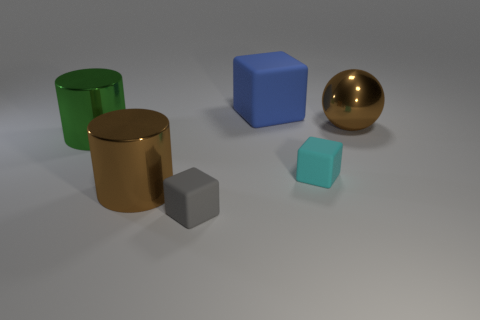

Step: 0
Reasoning Text:<think>The problem asks to identify and describe the objects present in the image. I will analyze the image to locate and describe each object.
To clearly identify the objects, I will highlight the relevant area with a bounding box.</think>


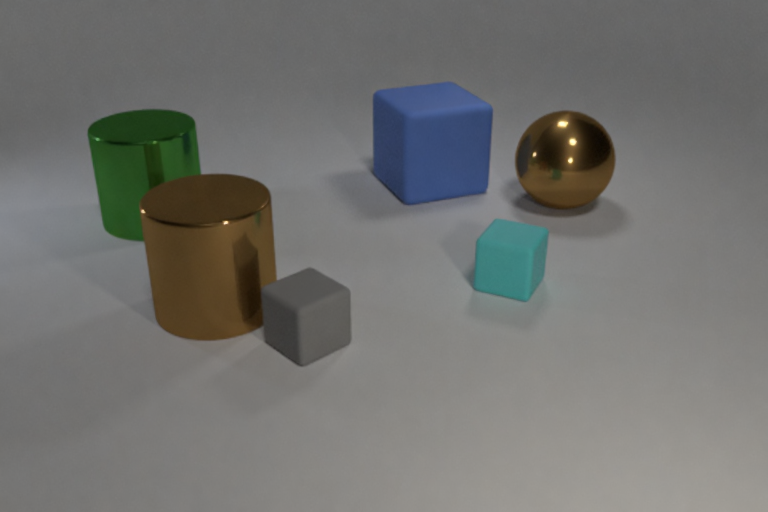

Step: 1
Reasoning Text:<think>The bounding box in the previous image clearly outlines a large green object. This object is a cylinder.
Next, I will highlight the second object within the bounding box to identify it.</think>


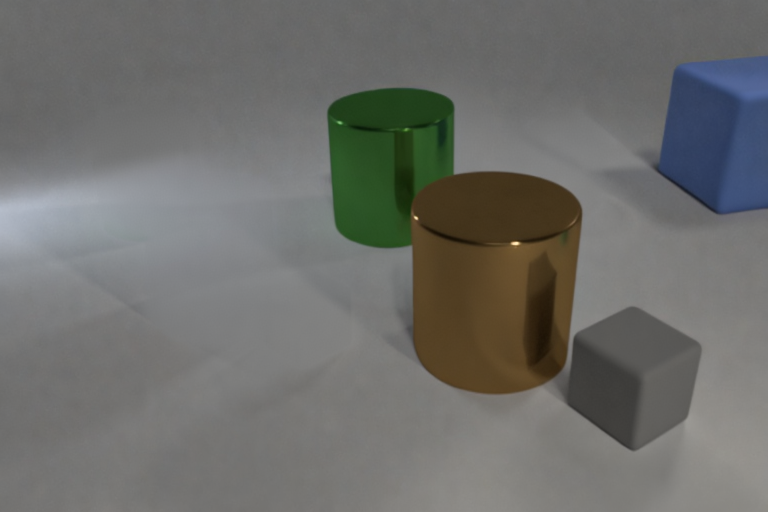

Step: 2
Reasoning Text:<think>The second bounding box outlines a large brown object. This object is also a cylinder.
Now, I will highlight the third object within the bounding box to identify it.</think>


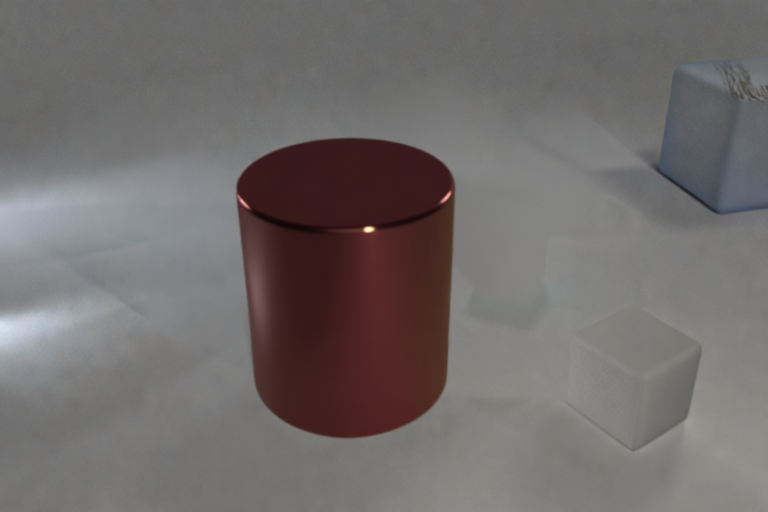

Step: 3
Reasoning Text:<think>The third bounding box outlines a large blue object. This object is a cube.
Finally, I will highlight the fourth object within the bounding box to identify it.</think>


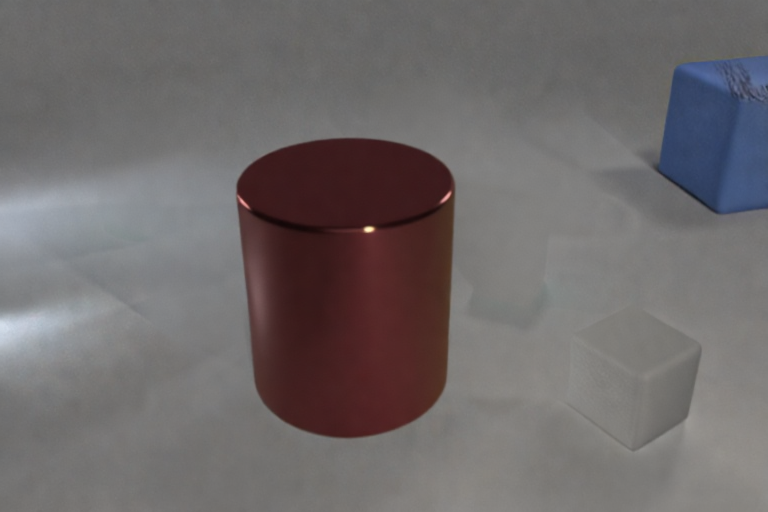

Step: 4
Reasoning Text:<think>The fourth bounding box outlines a large brown object. This object is a sphere.
Based on the visual analysis, the objects identified are a large green cylinder, a large brown cylinder, a large blue cube, and a large brown sphere.</think>


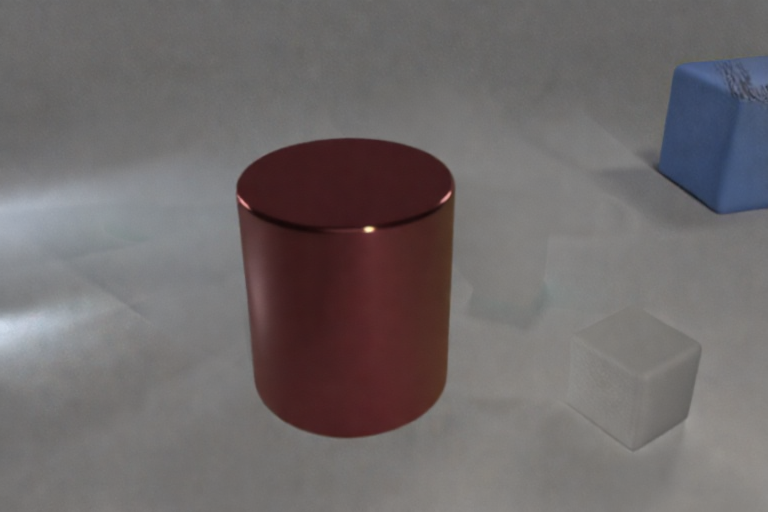

Step: 5
Reasoning Text:<think>The final answer provides a list of the identified objects, which matches the visual analysis.</think>


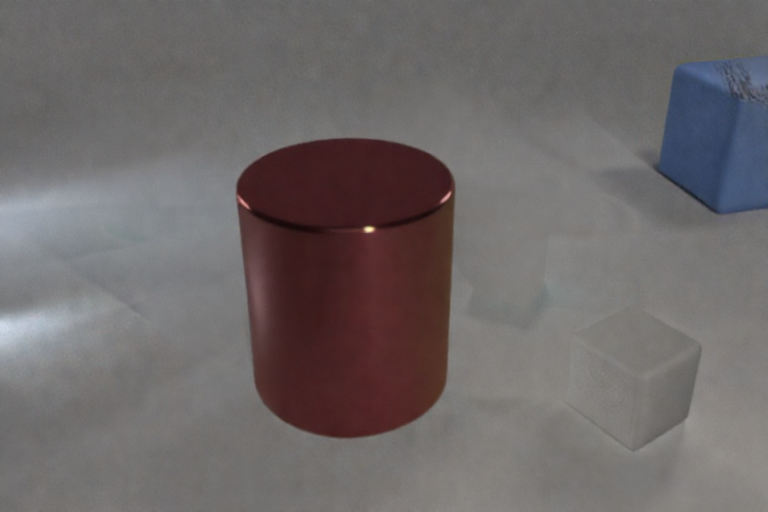

Step: 6
Reasoning Text:<answer>Final Answer: large cylinder large cylinder large cube large sphere</answer>


In [13]:
# display the reasoning process
print (prompt)
display(image)

print ("="*50)

for i, text in enumerate(reasoning_text):
    print (f"Step: {i}\nReasoning Text:{text}")
    if i==len(reasoning_text)-1:
        break
    
    display(reasoning_images[i])
    print ("="*50)

In [20]:
# import torch
# from diffusers import FluxPipeline

# pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
# pipe.to("cuda:7")

Loading pipeline components...:  57%|███████████████████████▍                 | 4/7 [00:01<00:01,  2.71it/s]


TypeError: Couldn't build proto file into descriptor pool: duplicate file name sentencepiece_model.proto

In [ ]:
# # generate image
# # prompt = "a tiny astronaut hatching from an egg on the moon"
# prompt = "a photo of a workspace desk with a lot of stuff"
# prompt = "a photo of a sign pointing northeast"
# prompt = "an arrow pointing northwest"
# prompt = "a connect the dots puzzle"
# prompt = "a top view (from an angle) of a brown and white cat with fluffy hair"
# prompt = "a top view (from an angle) of superman action figure on a table"
# prompt = "a side view captured from right of a superman action figure on a table"
# prompt = "a side view captured from right of a superman action figure on a table"

# images = pipe(
#     prompt=prompt,
#     guidance_scale=3.5,
#     height=768,
#     width=768,
#     num_inference_steps=25,
#     num_images_per_prompt=2,
# ).images
# display_alongside_batch(images)

# 2 - Custom Inference

In [19]:
import glob

puzzle_images = glob.glob('../FusionBench/data/train/visual_jigsaw_position/problems/images/*')
puzzle_images = glob.glob('../FusionBench/data/maze_train/maze_path_generation/images/*')
puzzle_images = glob.glob('../implicit-explicit-reasoning/data/frozenlake/test/images/*')

len(puzzle_images), puzzle_images

(881,
 ['../implicit-explicit-reasoning/data/frozenlake/test/images/sample_00215.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_000422.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_000277.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_00477.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_000437.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_00083.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_000042.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_00138.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_000186.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_00130.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_000094.png',
  '../implicit-explicit-reasoning/data/frozenlake/test/images/sample_00422.png',
  '../implicit-e

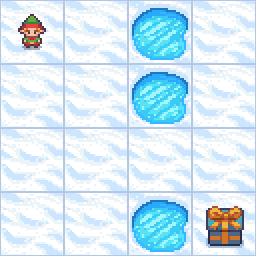

In [20]:
idx = 6
image = Image.open(puzzle_images[idx])
image

In [21]:
# Rest of inference code
from inferencer import InterleaveInferencer

inferencer = InterleaveInferencer(
    model=model, 
    vae_model=vae_model, 
    tokenizer=tokenizer, 
    vae_transform=vae_transform, 
    vit_transform=vit_transform, 
    new_token_ids=new_token_ids
)

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

inference_hyper=dict(
    do_sample=True,
    text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    # cfg_renorm_type="text_channel",
)

Question: Look at the FrozenLake grid above. The agent starts at S and needs to reach G (goal) while avoiding H (holes). What is the optimal sequence of moves?
Options:
A) Right, Down, Down, Right, Right, Right
B) Down, Left, Up, Left, Left, Right
C) Down, Down, Up, Left, Left, Left
D) Right, Down, Down, Down, Right, Right



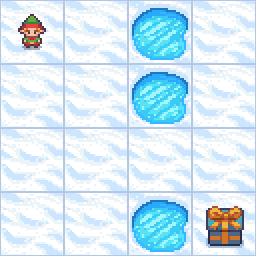

--------------------------------------------------
iteration: 0
To solve the problem of finding the optimal sequence of moves for the agent to reach the goal (G) from the start (S) while avoiding the holes (H), we can use a systematic approach. Here's a step-by-step analysis:

1. **Identify the Start and Goal Positions:**
   - The start position (S) is at the top-left corner of the grid.
   - The goal position (G) is at the bottom-right corner of the grid.

2. **Visualize the Grid:**
   - The grid has 3 rows and 3 columns.
   - The holes (H) are located at positions (1,3), (2,3), and (3,3).

3. **Analyze Each Option:**
   - **Option A: Right, Down, Down, Right, Right, Right**
     - Move Right from S to (1,2).
     - Move Down to (2,2).
     - Move Down to (3,2).
     - Move Right to (3,3) which is a hole, so this path is invalid.
   - **Option B: Down, Left, Up, Left, Left, Right**
     - Move Down from S to (2,1).
     - Move Left to (1,1).
     - Move Up to (2,1) which is already vi

100%|████████████████████████████████████████████████████████████████████| 49/49 [00:13<00:00,  3.63it/s]


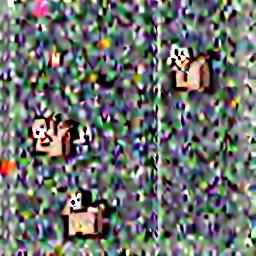

--------------------------------------------------
iteration: 1
: Right, Down, Down, Down, Right, Right**
     - Move Right from S to (1,2).
     - Move Down to (2,2).
     - Move Down to (3,2).
     - Move Down to (4,2) which is out of bounds, so this path is invalid.

6. **Re-evaluate the Options:**
   - **Option A: Right, Down, Down, Right, Right, Right**
     - Move Right from S to (1,2).
     - Move Down to (2,2).
     - Move Down to (3,2).
     - Move Right to (3,3) which is a hole, so this path is invalid.
   - **Option B: Down, Left, Up, Left, Left, Right**
     - Move Down from S to (2,1).
     - Move Left to (1,1).
     - Move Up to (2,1) which is already visited.
     - Move Left to (1,0) which is out of bounds, so this path is invalid.
   - **Option C: Down, Down, Up, Left, Left, Left**
     - Move Down from S to (2,1).
     - Move Down to (3,1).
     - Move Up to (2,1) which is already visited.
     - Move Left to (2,0) which is out of bounds, so this path is invalid.
   -

100%|████████████████████████████████████████████████████████████████████| 49/49 [00:13<00:00,  3.59it/s]


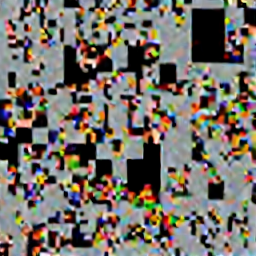

--------------------------------------------------
iteration: 2
- **Option A: Right, Down, Down, Right, Right, Right**
     - Move Right from S to (1,2).
     - Move Down to (2,2).
     - Move Down to (3,2).
     - Move Right to (3,3) which is a hole, so this path is invalid.
   - **Option B: Down, Left, Up, Left, Left, Right**
     - Move Down from S to (2,1).
     - Move Left to (1,1).
     - Move Up to (2,1) which is already visited.
     - Move Left to (1,0) which is out of bounds, so this path is invalid.
   - **Option C: Down, Down, Up, Left, Left, Left**
     - Move Down from S to (2,1).
     - Move Down to (3,1).
     - Move Up to (2,1) which is already visited.
     - Move Left to (2,0) which is out of bounds, so this path is invalid.
   - **Option D: Right, Down, Down, Down, Right, Right**
     - Move Right from S to (1,2).
     - Move Down to (2,2).
     - Move Down to (3,2).
     - Move Down to (4,2) which is out of bounds, so this path is invalid.

10. **Re-evaluate the Op

100%|████████████████████████████████████████████████████████████████████| 49/49 [00:13<00:00,  3.63it/s]


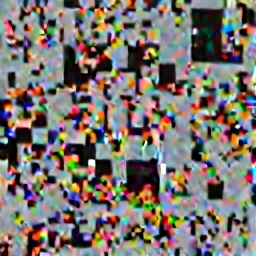

--------------------------------------------------
iteration: 3
: Down, Left, Up, Left, Left, Right**
      - Move Down from S to (2,1).
      - Move Left to (1,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (1,0) which is out of bounds, so this path is invalid.
    - **Option C: Down, Down, Up, Left, Left, Left**
      - Move Down from S to (2,1).
      - Move Down to (3,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (2,0) which is out of bounds, so this path is invalid.
    - **Option D: Right, Down, Down, Down, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Down to (4,2) which is out of bounds, so this path is invalid.

13. **Re-evaluate the Options:**
    - **Option A: Right, Down, Down, Right, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Right to (3,3) which is a hole, so this p

100%|████████████████████████████████████████████████████████████████████| 49/49 [00:13<00:00,  3.62it/s]


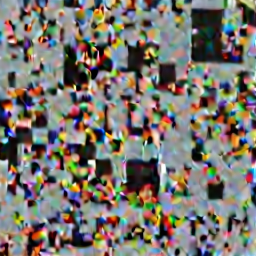

--------------------------------------------------
iteration: 4
Option C: Down, Down, Up, Left, Left, Left**
      - Move Down from S to (2,1).
      - Move Down to (3,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (2,0) which is out of bounds, so this path is invalid.
    - **Option D: Right, Down, Down, Down, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Down to (4,2) which is out of bounds, so this path is invalid.

16. **Re-evaluate the Options:**
    - **Option A: Right, Down, Down, Right, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Right to (3,3) which is a hole, so this path is invalid.
    - **Option B: Down, Left, Up, Left, Left, Right**
      - Move Down from S to (2,1).
      - Move Left to (1,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (1,0) which is out of bounds, s

100%|████████████████████████████████████████████████████████████████████| 49/49 [00:13<00:00,  3.62it/s]


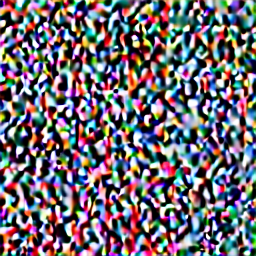

--------------------------------------------------
iteration: 5
- **Option D: Right, Down, Down, Down, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Down to (4,2) which is out of bounds, so this path is invalid.

19. **Re-evaluate the Options:**
    - **Option A: Right, Down, Down, Right, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Right to (3,3) which is a hole, so this path is invalid.
    - **Option B: Down, Left, Up, Left, Left, Right**
      - Move Down from S to (2,1).
      - Move Left to (1,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (1,0) which is out of bounds, so this path is invalid.
    - **Option C: Down, Down, Up, Left, Left, Left**
      - Move Down from S to (2,1).
      - Move Down to (3,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (2,0) which is out of bound

100%|████████████████████████████████████████████████████████████████████| 49/49 [00:13<00:00,  3.64it/s]


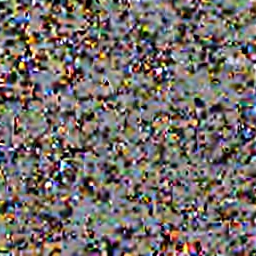

--------------------------------------------------
iteration: 6
Re-evaluate the Options:**
    - **Option A: Right, Down, Down, Right, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Right to (3,3) which is a hole, so this path is invalid.
    - **Option B: Down, Left, Up, Left, Left, Right**
      - Move Down from S to (2,1).
      - Move Left to (1,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (1,0) which is out of bounds, so this path is invalid.
    - **Option C: Down, Down, Up, Left, Left, Left**
      - Move Down from S to (2,1).
      - Move Down to (3,1).
      - Move Up to (2,1) which is already visited.
      - Move Left to (2,0) which is out of bounds, so this path is invalid.
    - **Option D: Right, Down, Down, Down, Right, Right**
      - Move Right from S to (1,2).
      - Move Down to (2,2).
      - Move Down to (3,2).
      - Move Down to (4,2) which is out of bounds, 

 14%|█████████▊                                                           | 7/49 [00:01<00:11,  3.53it/s]

KeyboardInterrupt



In [22]:
INTERLEAVED_SYSTEM_PROMPT = '''You are an AI reasoning assistant capable of step-by-step interleaved text and visual chain of thought. Think step by step and use visual aids to enhance your problem-solving. Provide your final conclusion clearly in the format of "Final Answer: <answer here>"'''

prompt = '''Subtract all cylinders. Add 1 red sphere. How many objects are left?'''
prompt = '''Count how many objects are there in total which are not cylinders'''
prompt = '''Count how many objects are there in total which are not cylinders or spheres'''

prompt = '''Given this 2x2 jigsaw puzzle can you generate what the original image looks like showing your thinking process to solve this'''
prompt = '''Given this 2x2 jigsaw puzzle can you generate what the original image looks like. Directly answer without any reasoning'''

prompt = '''Count how many objects are there in total which are not cylinders or spheres. Direclty answer'''

prompt = '''Subtract all cylinders. Add 1 red sphere. How many objects are left?'''
# prompt = '''Subtract all cylinders. Add 1 red sphere. How many objects are left?'''
prompt = '''Count how many objects are there in total which are not cylinders or spheres after I add two more cubes to this'''
prompt = '''Given this 2x2 jigsaw puzzle. Lets say if I were to solve it. Where would the piece 3 go after solving the puzzle (note: I am asking after solving the puzzle, not in the current state).
            Options 
            A: (top-left), 
            B: (top-right), 
            C: (bottom-left), 
            D: (bottom-right), 

        Give your answer as A, B, C, D
        '''
prompt = '''Given this 2x2 jigsaw puzzle can you generate what the original image looks like showing your thinking process to solve this'''
prompt = '''Given this 2x2 jigsaw puzzle can you generate the original image.'''
prompt = '''Given this 2x2 jigsaw puzzle (i.e. with original image pieces just jumbled and shuffled. can you generate answer what is the original image in text and then generate the original image.'''
prompt = """Given this maze puzzle, with start as green dot and end as blue dot, can you draw a red line indicating the solution of the maze"""

prompt = """Which will be taller, if you put the cylinder on top of the other cylinder, or stack the two cubes vertically"""
prompt = """Change color black to red for the maze"""
prompt = """what is this"""
prompt = '''what is in this image? Describe please'''
prompt = '''What is the path if the agent (at 0,0) needs to go the gift (4,4 at bottomright)'''
prompt = '''Can you move the (0,0) just one step down?'''

prompt = '''Question: Look at the FrozenLake grid above. The agent starts at S and needs to reach G (goal) while avoiding H (holes). What is the optimal sequence of moves?
Options:
A) Right, Down, Down, Down, Right, Right
B) Right, Down, Down, Right, Right, Right
C) Down, Left, Up, Left, Left, Right
D) Down, Down, Up, Left, Left, Left
'''

prompt = '''Question: Look at the FrozenLake grid above. The agent starts at S and needs to reach G (goal) while avoiding H (holes). What is the optimal sequence of moves?
Options:
A) Right, Down, Down, Right, Right, Right
B) Down, Left, Up, Left, Left, Right
C) Down, Down, Up, Left, Left, Left
D) Right, Down, Down, Down, Right, Right
'''

# Please provide your answer in <ANSWER> tags. e.g., <ANSWER>A</ANSWER> or <ANSWER>B</ANSWER> or <ANSWER>C</ANSWER> or <ANSWER>D</ANSWER>.

# image = Image.open('test_images/image.png')

print(prompt)
display(image)
print('-'*50)

#####################################################
# hyperparameters
#####################################################
max_reasoning_steps = 10 # set -1 for unlimited
include_visual_reasoning = True
max_reasoning_steps = 100 if max_reasoning_steps < 0 else max_reasoning_steps #


#####################################################
# inference
#####################################################
reasoning_text = []
reasoning_images = []
image_paths = []  # Store relative paths to images

# Create input with multiple images properly flattened
if image is not None:
    if isinstance(image, list):
        current_input = [prompt] + image  # Flatten the list of images
    else:
        current_input = [prompt, image]
else:
    current_input = [prompt]

# Loop until no more vision_start tokens
iteration = 0
while True:    
    # Get understanding output
    print(f"iteration: {iteration}")
    output = inferencer.interleave_inference(current_input, understanding_output=True, system_prompt=INTERLEAVED_SYSTEM_PROMPT, **inference_hyper)

    # Check for stopping conditions
    has_final_answer = 'Final Answer:' in output[0] or '<answer>' in output[0]
    
    # Stop if we have a final answer OR if there's no vision token (no more images to generate)
    # should_stop = has_final_answer or not has_vision_token
    should_stop = has_final_answer or iteration >= max_reasoning_steps

    if should_stop:
        if output[0].strip():
            extracted_text = output[0].split('<|im_end|>')[0].split('<|im_start|>')[1]
            reasoning_text.append(extracted_text)
            print(f"{extracted_text}")
            current_input = current_input + [extracted_text]
        break
    
    extracted_text = output[0].split('<|im_end|>')[0].split('<|im_start|>')[1]
    reasoning_text.append(extracted_text)
    print(f"{extracted_text}")
    
    # Generate image based on current reasoning
    current_input_with_reasoning = current_input + [extracted_text]
    if include_visual_reasoning:
        output = inferencer.interleave_inference(current_input_with_reasoning, system_prompt=INTERLEAVED_SYSTEM_PROMPT, **inference_hyper)
        image_output = output[0]
    
        # Save and collect the generated image
        reasoning_images.append(image_output)
        display(image_output)
        
        # Update input for next iteration
        current_input = current_input_with_reasoning + [image_output]
    else:
        # current_input = current_input_with_reasoning + [image]
        current_input = current_input_with_reasoning[:-1]
        extracted_text = extracted_text.replace('</think>','')
        extracted_text = extracted_text.replace('<think>','')
        current_input = current_input + [extracted_text]
    iteration += 1
    print('-'*50)

Change color black to red for the maze


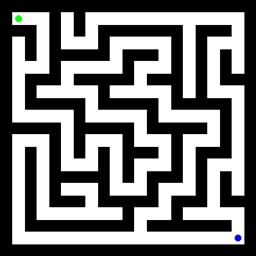

Step: 0
Reasoning Text:<think>Let's visualize the maze with the start and goal points clearly marked.</think>


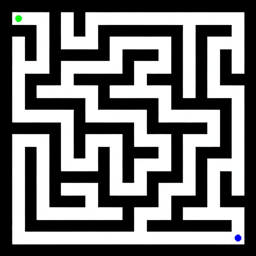

Step: 1
Reasoning Text:<think>Now, I will trace the shortest path from the start to the goal using the A* algorithm, highlighting the chosen moves.</think>


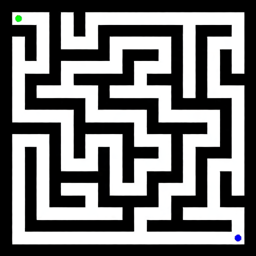

Step: 2
Reasoning Text:<think>The image shows the sequence of moves selected by the A* algorithm to reach the goal from the start.</think>


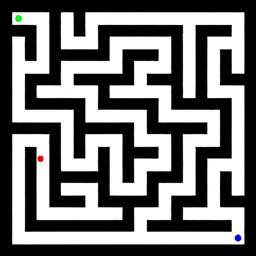

Step: 3
Reasoning Text:<answer>Final Answer: It takes 40 steps to reach the goal from the start.</answer>


In [89]:
# display the reasoning process
print (prompt)
display(image.resize((256,256)))

print ("="*50)

for i, text in enumerate(reasoning_text):
    print (f"Step: {i}\nReasoning Text:{text}")
    if i==len(reasoning_text)-1:
        break
    
    display(reasoning_images[i].resize((256,256)))
    print ("="*50)

In [ ]:
# Save reasoning data to JSON
reasoning_data = {
    "timestamp": timestamp,
    "prompt": prompt,
    "system_prompt": INTERLEAVED_SYSTEM_PROMPT,
    "problem_image_paths": problem_image_paths if problem_image_paths else None,
    "response": [
        {
            "step": i + 1,
            "text": text,
            "image_path": image_paths[i] if i < len(image_paths) else None
        }
        for i, text in enumerate(reasoning_text)
    ],
    "total_steps": len(reasoning_text),
    "total_images": len(image_paths)
}

# Save JSON file
json_path = os.path.join(output_folder, "reasoning_data.json")
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(reasoning_data, f, indent=2, ensure_ascii=False)

print(f"\nReasoning complete!")
print(f"Output folder: {output_folder}")
print(f"JSON metadata: {json_path}")
print(f"Generated {len(image_paths)} images and {len(reasoning_text)} text steps")